<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250709/%E7%A2%BA%E8%AA%8D%E3%83%86%E3%82%B9%E3%83%88%EF%BC%887%E6%9C%889%E6%97%A5%EF%BC%89%E8%A7%A3%E8%AA%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#最適化モデリング 確認テスト
---
## 準備
まず、以下のセルを実行し、演習に必要なライブラリをインストールせよ。

In [1]:
%%capture
# 最適化ライブラリ python-mipをインストール
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 必要なライブラリのインポート
import mip
import pandas as pd
import numpy as np

---
#問題1

3つの工場（F1, F2, F3）から3つの倉庫（W1, W2, W3）へ製品を輸送する計画を考える。各工場の供給量、各倉庫の需要量、および工場から倉庫への単位輸送コストが以下の表で与えられている。
供給量を超えない範囲で需要を満たすような輸送計画で、
総輸送コストを最小化するものを求め、
その最小コストを解答せよ。

| | 倉庫 W1 | 倉庫 W2 | 倉庫 W3 | **供給量** |
| :--- | :---: | :---: | :---: | :---: |
| **工場 F1** | 5 | 7 | 8 | 120 |
| **工場 F2**| 2 | 6 | 6 | 150 |
| **工場 F3**| 8 | 5 | 9 | 100 |
| **需要量** | 90 | 110 | 130 | |


In [2]:
#問題1: 解答コード

# --- データ定義 ---
factories = ['F1', 'F2', 'F3']
warehouses = ['W1', 'W2', 'W3']

# 供給量
supply = {'F1': 120, 'F2': 150, 'F3': 100}

# 需要量
demand = {'W1': 90, 'W2': 110, 'W3': 130}

# 輸送コスト
costs = {
    'F1': {'W1': 5, 'W2': 7, 'W3': 8},
    'F2': {'W1': 2, 'W2': 6, 'W3': 6},
    'F3': {'W1': 8, 'W2': 5, 'W3': 9}
}

# --- モデル構築 ---
model1 = mip.Model(name="Transportation_ex1", sense=mip.MINIMIZE)

# 変数の定義
x = {(i, j): model1.add_var(name=f"x_{i}_{j}", var_type=mip.CONTINUOUS, lb=0)
     for i in factories for j in warehouses}

# 目的関数の設定
model1.objective = mip.xsum(costs[i][j] * x[i, j] for i in factories for j in warehouses)

# 制約条件の追加
# 供給制約
for i in factories:
    model1 += mip.xsum(x[i, j] for j in warehouses) <= supply[i], f"supply_{i}"

# 需要制約
for j in warehouses:
    model1 += mip.xsum(x[i, j] for i in factories) >= demand[j], f"demand_{j}"

# --- 求解と結果表示 ---
status1 = model1.optimize()

if status1 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小総輸送コスト (最適値): {model1.objective_value:.2f}")

    # 最適な輸送計画を表示
    print("\n--- 最適輸送計画 ---")
    transport_plan = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            transport_plan.loc[i, j] = x[i, j].x #if x[i, j].x > 1e-6 else 0
    print(transport_plan)
elif status1 == mip.OptimizationStatus.INFEASIBLE:
    print("\n実行不可能: 制約を満たす解が存在しません。")
elif status1 == mip.OptimizationStatus.UNBOUNDED:
    print("\n非有界: 目的関数を無限に小さく（または大きく）できます。")
else:
    print(f"\n求解失敗 (ステータス: {status1})")

最小総輸送コスト (最適値): 1670.00

--- 最適輸送計画 ---
      W1     W2    W3
F1   0.0   10.0  70.0
F2  90.0    0.0  60.0
F3   0.0  100.0   0.0


---
#問題1-1

問題1に、工場F3から倉庫W2への輸送量の上限 90 が加わった場合の
最小コストを解答せよ。


##問題1-1の解説

**定式化**

* **インデックス**
  * $i$: 供給地（工場）の集合とインデックス $i \in F = \{F1, F2, F3\}$
  * $j$: 需要地（倉庫）の集合とインデックス $j \in W = \{W1, W2, W3\}$

* **パラメータ**
    * $s_i$: 工場 $i$ の供給量
    * $d_j$: 倉庫 $j$ の需要量
    * $c_{ij}$: 工場 $i$ から倉庫 $j$ への単位輸送コスト

* **決定変数**
    * $x_{ij}$: 工場 $i$ から倉庫 $j$ への輸送量（非負連続変数）

* **目的関数**
    総輸送コストを最小化するため、目的関数は以下のように定義される。
    $$\min Z = \sum_{i} \sum_{j} c_{ij} x_{ij}$$

* **制約条件**
    1.  **供給制約**: 各工場からの輸送量の合計は、その工場の供給量を超えてはならない。
$$\sum_{j} x_{ij} \le s_i \quad (\forall i)$$
    2.  **需要制約**: 各倉庫への輸送量の合計は、その倉庫の需要量を満たさなければならない。
$$\sum_{i} x_{ij} \ge d_j \quad (\forall j)$$
    3. **輸送量の上限制約**: 工場F3から倉庫W2への輸送量には上限があり 90 とする。
$$
x_{F3,W2} \le 90
$$
    3.  **非負制約**: 輸送量は0以上でなければならない。
$$x_{ij} \ge 0 \quad (\forall i, j)$$


In [3]:
#問題1: 解答コード

# --- データ定義 ---
factories = ['F1', 'F2', 'F3']
warehouses = ['W1', 'W2', 'W3']

# 供給量
supply = {'F1': 120, 'F2': 150, 'F3': 100}

# 需要量
demand = {'W1': 90, 'W2': 110, 'W3': 130}

# 輸送コスト
costs = {
    'F1': {'W1': 5, 'W2': 7, 'W3': 8},
    'F2': {'W1': 2, 'W2': 6, 'W3': 6},
    'F3': {'W1': 8, 'W2': 5, 'W3': 9}
}

# --- モデル構築 ---
model1 = mip.Model(name="Transportation_ex1", sense=mip.MINIMIZE)

# 変数の定義
x = {(i, j): model1.add_var(name=f"x_{i}_{j}", var_type=mip.CONTINUOUS, lb=0)
     for i in factories for j in warehouses}

# 目的関数の設定
model1.objective = mip.xsum(costs[i][j] * x[i, j] for i in factories for j in warehouses)

# 制約条件の追加
# 供給制約
for i in factories:
    model1 += mip.xsum(x[i, j] for j in warehouses) <= supply[i], f"supply_{i}"

# 需要制約
for j in warehouses:
    model1 += mip.xsum(x[i, j] for i in factories) >= demand[j], f"demand_{j}"

# 輸送量の上限制約
model1 += x['F3', 'W2'] <= 90, "additional_constraint"

# --- 求解と結果表示 ---
status1 = model1.optimize()

if status1 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小総輸送コスト (最適値): {model1.objective_value:.2f}")

    # 最適な輸送計画を表示
    print("\n--- 最適輸送計画 ---")
    transport_plan = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            transport_plan.loc[i, j] = x[i, j].x #if x[i, j].x > 1e-6 else 0
    print(transport_plan)
elif status1 == mip.OptimizationStatus.INFEASIBLE:
    print("\n実行不可能: 制約を満たす解が存在しません。")
elif status1 == mip.OptimizationStatus.UNBOUNDED:
    print("\n非有界: 目的関数を無限に小さく（または大きく）できます。")
else:
    print(f"\n求解失敗 (ステータス: {status1})")

最小総輸送コスト (最適値): 1690.00

--- 最適輸送計画 ---
      W1    W2    W3
F1   0.0  20.0  70.0
F2  90.0   0.0  60.0
F3   0.0  90.0   0.0


---
#問題2

あなたは重さの容量が20のナップザックを持っている。価値と重さが異なる6つのアイテムがある。ナップザックの容量を超えないようにアイテムを選び、総価値が最大になるようにしたい。最大総価値を求めよ。

| アイテム | 0 | 1 | 2 | 3 | 4 | 5 |
| :--- | :-: | :-: | :-: | :-: | :-: | :-: |
| **価値** | 50 | 65 | 140 | 100 | 70 | 80 |
| **重さ** | 4 | 5 | 12 | 9 | 6 | 7 |



In [4]:
#問題2: 解答コード

values = [50, 65, 140, 100, 70, 80]
weights = [4, 5, 12, 9, 6, 7]
capacity = 20
num_items = len(values)
item_indices = range(num_items)

# --- モデル構築 ---
model2 = mip.Model(name="Knapsack_ex2", sense=mip.MAXIMIZE)

x_k2 = [model2.add_var(var_type=mip.BINARY, name=f"x_{i}") for i in item_indices]

# 目的関数
model2.objective = mip.xsum(values[i] * x_k2[i] for i in item_indices)

# 制約条件
# 容量制約
model2 += mip.xsum(weights[i] * x_k2[i] for i in item_indices) <= capacity, "capacity"

# --- 求解と結果表示 ---
status2 = model2.optimize()

if status2 == mip.OptimizationStatus.OPTIMAL:
    print(f"解答:")
    print(f"最大総価値: {model2.objective_value:.2f}")

    for item in range(num_items):
        if x_k2[item].x > 0.99:
            print(f"アイテム {item} をナップザックに入れる")
else:
    print(f"最適解が見つかりませんでした。ステータス: {status2}")

解答:
最大総価値: 235.00
アイテム 1 をナップザックに入れる
アイテム 3 をナップザックに入れる
アイテム 4 をナップザックに入れる


---
#問題2-1

問題2に、以下の2つの追加制約がある場合の最大総価値を求めよ。

* アイテム1（価値65, 重さ5）を選択する場合、アイテム5（価値80, 重さ7）も必ず選択しなければならない。
* アイテム2（価値140, 重さ12）とアイテム3（価値100, 重さ9）は、同時に選択することはできない。


##問題2の解説

**定式化**
* **インデックス**
  * $i$: アイテムのインデックス, $i \in \{0, ..., 5\}$
* **パラメータ**
  * $v_i$: アイテム $i$ の価値
  * $w_i$: アイテム $i$ の重さ
  * $C$: ナップザックの容量
* **決定変数**
  * $x_i$: アイテム $i$ をナップザックに入れる場合に1、入れない場合に0をとるバイナリ変数
* **目的関数**
    $$\max Z = \sum_{i} v_i x_i$$
* **制約条件**
    $$\sum_{i} w_i x_i \le C$$

* **追加制約1**: アイテム1を選択する($x_1=1$)なら、アイテム5を選択する($x_5=1$)。これは $x_1 \le x_5$ という線形不等式で表現できる。
* **追加制約2**: アイテム2とアイテム3は同時に選択できない。これは $x_2 + x_3 \le 1$ という線形不等式で表現できる。


In [5]:
#問題2: 解答コード

values = [50, 65, 140, 100, 70, 80]
weights = [4, 5, 12, 9, 6, 7]
capacity = 20
num_items = len(values)
item_indices = range(num_items)

# --- モデル構築 ---
model2 = mip.Model(name="Knapsack_ex2", sense=mip.MAXIMIZE)

x_k2 = [model2.add_var(var_type=mip.BINARY, name=f"x_{i}") for i in item_indices]

# 目的関数
model2.objective = mip.xsum(values[i] * x_k2[i] for i in item_indices)

# 制約条件
# 容量制約
model2 += mip.xsum(weights[i] * x_k2[i] for i in item_indices) <= capacity, "capacity"

# ★追加制約1: アイテム1(idx=1) -> アイテム5(idx=5)
model2 += x_k2[1] <= x_k2[5], "dependency_1"

# ★追加制約2: アイテム3(idx=2)とアイテム4(idx=3)は同時に選択不可
model2 += x_k2[2] + x_k2[3] <= 1, "dependency_2"

# --- 求解と結果表示 ---
status2 = model2.optimize()

if status2 == mip.OptimizationStatus.OPTIMAL:
    print(f"解答:")
    print(f"最大総価値: {model2.objective_value:.2f}")

    for item in range(num_items):
        if x_k2[item].x > 0.99:
            print(f"アイテム {item} をナップザックに入れる")
else:
    print(f"最適解が見つかりませんでした。ステータス: {status2}")

解答:
最大総価値: 230.00
アイテム 0 をナップザックに入れる
アイテム 3 をナップザックに入れる
アイテム 5 をナップザックに入れる


---
#問題3

あるエージェントが、スタート地点'S'からゴール地点'G'まで移動する。各移動経路（枝）には、移動コスト（時間）と、通行料がかかる。
**総移動コスト（時間）のみ**
を考えコストを最小にする経路を求め、その最小コストを解答せよ。

* **ノード**: {S, A, B, C, D, G}
* **枝 (始点, 終点, 移動コスト, 通行料)**:
    * (S, A, 4, 5), (S, B, 8, 3)
    * (A, B, 2, 6), (A, C, 6, 8)
    * (B, C, 3, 5), (B, D, 10, 4)
    * (C, G, 5, 7)
    * (D, C, 2, 4), (D, G, 3, 9)
* **通行料上限**: 20

In [7]:
#問題3

# --- データ定義 ---
sp_knap_edges = [
    ('S', 'A', 4, 5), ('S', 'B', 8, 3),
    ('A', 'B', 2, 6), ('A', 'C', 6, 8),
    ('B', 'C', 3, 5), ('B', 'D', 10, 4),
    ('C', 'G', 5, 7),
    ('D', 'C', 2, 4), ('D', 'G', 3, 9)
]
sp_knap_nodes = set(u for u, v, cost, fee in sp_knap_edges) | \
                set(v for u, v, cost, fee in sp_knap_edges)
start_node_spk = 'S'
end_node_spk = 'G'
fee_capacity = 20

# --- モデル構築 ---
model3 = mip.Model(name="SP", sense=mip.MINIMIZE)

# 変数
x_spk = {(u, v): model3.add_var(var_type=mip.BINARY, name=f"x_{u}_{v}")
         for u, v, cost, fee in sp_knap_edges}

# 目的関数 (移動コスト最小化)
model3.objective = mip.xsum(cost * x_spk[u, v] for u, v, cost, fee in sp_knap_edges)

# 制約条件
# フロー保存則
for node in sp_knap_nodes:
    flow_out = mip.xsum(x_spk[u, v] for u, v, cost, fee in sp_knap_edges if u == node)
    flow_in = mip.xsum(x_spk[u, v] for u, v, cost, fee in sp_knap_edges if v == node)
    if node == start_node_spk:
        model3 += flow_out - flow_in == 1, f"flow_{node}"
    elif node == end_node_spk:
        model3 += flow_out - flow_in == -1, f"flow_{node}"
    else:
        model3 += flow_out - flow_in == 0, f"flow_{node}"

# --- 求解と結果表示 ---
status3 = model3.optimize()

if status3 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小移動コスト: {model3.objective_value:.2f}")
    total_fee = sum(fee * x_spk[u, v].x for u, v, cost, fee in sp_knap_edges)
    print(f"経路の合計特別料金: {total_fee}")
else:
    print(f"最適解が見つかりませんでした。ステータス: {status3}")

最小移動コスト: 14.00
経路の合計特別料金: 23.0


---
#問題3-1

問題3で、
移動コスト（時間）に加え通行料を考える。
**総通行料を20以内に抑えつつ、総移動コスト（時間）を最小にする**経路を求め、その最小コストを解答せよ。

##問題3の解説

**定式化**
最短路問題の定式化を基本とし、追加の制約を設ける。
* **パラメータ**:
  * $c_{ij}$: 枝 $(i, j)$ の移動コスト
  * $f_{ij}$: 枝 $(i, j)$ の通行料
  * $F_{max}$: 通行料の上限
* **決定変数**:
  * $x_{ij}$: 枝 $(i, j)$ を経路上で使用する場合に1、しない場合に0のバイナリ変数
* **目的関数 (移動コスト最小化)**:
    $$\min Z = \sum_{(i,j) \in E} c_{ij} x_{ij}$$
* **制約条件**:
    1.  **始点**: 始点からは1つの経路が出ていく。
        $$\sum_{j:(s,j)\in E} x_{sj} = 1$$
    2.  **終点**: 終点には1つの経路が入ってくる。
        $$ \sum_{j:(j,t)\in E} x_{jt} = 1$$
    3.  **中間ノード**:
ノード$k$から出る経路の枝数と入る枝数は等しい。
$$\sum_{j:(k,j)\in E} x_{kj} - \sum_{j:(j,k)\in E} x_{jk} = 0 \quad (\forall k \in V \setminus \{s, t\})$$
    4.  **予算制約**: 選択した経路の総通行料は上限を超えない。
        $$\sum_{(i,j) \in E} f_{ij} x_{ij} \le F_{max}$$


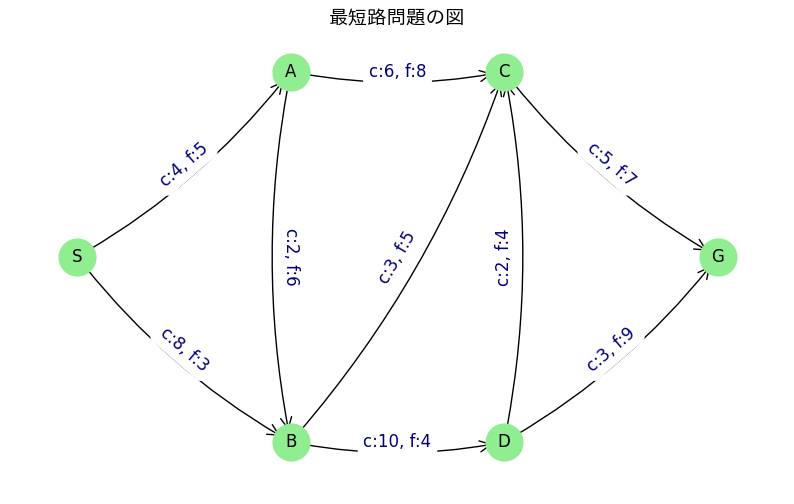

In [ ]:
#@title 図示
# グラフ描画に必要なライブラリをインポート
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib # ← 日本語表示のためにインポート

# 1. データ定義
# 枝のリスト (始点, 終点, 移動コスト, 通行料)
sp_knap_edges = [
    ('S', 'A', 4, 5), ('S', 'B', 8, 3),
    ('A', 'B', 2, 6), ('A', 'C', 6, 8),
    ('B', 'C', 3, 5), ('B', 'D', 10, 4),
    ('C', 'G', 5, 7),
    ('D', 'C', 2, 4), ('D', 'G', 3, 9)
]

# 事前計算による最適経路 (コスト15, 通行料20)
# この経路は総通行料を20以内に抑えつつ、総移動コストを最小にする経路です。
optimal_path_edges = [] #[('S', 'A'), ('A', 'C'), ('C', 'G')]

# 2. グラフの構築
# 有向グラフ (Directed Graph) を作成
G = nx.DiGraph()

# グラフに枝と属性（コストと通行料）を追加
for u, v, cost, fee in sp_knap_edges:
    G.add_edge(u, v, cost=cost, fee=fee)

# 3. 描画の準備
# ノードの位置を固定して見やすくする
pos = {
    'S': [0, 2], 'A': [2, 3], 'B': [2, 1],
    'D': [4, 1], 'C': [4, 3], 'G': [6, 2]
}

# 枝のラベルを作成 (例: "cost: 4, fee: 5")
edge_labels = {}
for u, v, data in G.edges(data=True):
    edge_labels[(u, v)] = f"c:{data['cost']}, f:{data['fee']}"

# 枝の色と太さを設定 (最適経路をハイライト)
edge_colors = []
edge_widths = []
for u, v in G.edges():
    if (u, v) in optimal_path_edges:
        edge_colors.append('red')
        edge_widths.append(2.5)
    else:
        edge_colors.append('black')
        edge_widths.append(1.0)

# 4. グラフの描画
plt.figure(figsize=(10, 6)) # 図のサイズを設定

# ノードを描画
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightgreen')

# 枝を描画
nx.draw_networkx_edges(G, pos,
                       edge_color=edge_colors,
                       width=edge_widths,
                       arrows=True,
                       arrowstyle='->',
                       arrowsize=20,
                       connectionstyle='arc3,rad=0.1')

# ノード名をラベルとして描画
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# 枝の属性(コストと通行料)をラベルとして描画
nx.draw_networkx_edge_labels(G, pos, font_size=12, edge_labels=edge_labels, font_color='navy')

# グラフのタイトルと表示設定
plt.title('最短路問題の図', size=14)
plt.axis('off') # 軸を非表示
plt.show()

In [8]:
#問題3

# --- データ定義 ---
sp_knap_edges = [
    ('S', 'A', 4, 5), ('S', 'B', 8, 3),
    ('A', 'B', 2, 6), ('A', 'C', 6, 8),
    ('B', 'C', 3, 5), ('B', 'D', 10, 4),
    ('C', 'G', 5, 7),
    ('D', 'C', 2, 4), ('D', 'G', 3, 9)
]
sp_knap_nodes = set(u for u, v, cost, fee in sp_knap_edges) | \
                set(v for u, v, cost, fee in sp_knap_edges)
start_node_spk = 'S'
end_node_spk = 'G'
fee_capacity = 20

# --- モデル構築 ---
model3 = mip.Model(name="SP", sense=mip.MINIMIZE)

# 変数
x_spk = {(u, v): model3.add_var(var_type=mip.BINARY, name=f"x_{u}_{v}")
         for u, v, cost, fee in sp_knap_edges}

# 目的関数 (移動コスト最小化)
model3.objective = mip.xsum(cost * x_spk[u, v] for u, v, cost, fee in sp_knap_edges)

# 制約条件
# フロー保存則
for node in sp_knap_nodes:
    flow_out = mip.xsum(x_spk[u, v] for u, v, cost, fee in sp_knap_edges if u == node)
    flow_in = mip.xsum(x_spk[u, v] for u, v, cost, fee in sp_knap_edges if v == node)
    if node == start_node_spk:
        model3 += flow_out - flow_in == 1, f"flow_{node}"
    elif node == end_node_spk:
        model3 += flow_out - flow_in == -1, f"flow_{node}"
    else:
        model3 += flow_out - flow_in == 0, f"flow_{node}"

# 通行料予算制約
model3 += mip.xsum(fee * x_spk[u, v] for u, v, cost, fee in sp_knap_edges) <= fee_capacity, "fee_budget"

# --- 求解と結果表示 ---
status3 = model3.optimize()

if status3 == mip.OptimizationStatus.OPTIMAL:
    print(f"演習問題9の解答:")
    print(f"最小移動コスト: {model3.objective_value:.2f}")
    total_fee = sum(fee * x_spk[u, v].x for u, v, cost, fee in sp_knap_edges)
    print(f"経路の合計特別料金: {total_fee}")

else:
    print(f"最適解が見つかりませんでした。ステータス: {status3}")

演習問題9の解答:
最小移動コスト: 15.00
経路の合計特別料金: 20.0


---
#問題4

以下の表に示したような栄養基準を満たしつつ食費を最小化する問題を考える。
このとき、最小コストを求めよ。

**食品データ**

| 食品名 | 単位 | コスト(円) | カロリー(kcal) | タンパク質(g) | ビタミンC(mg) |
|:--- |:--- |:---: |:---: |:---: |:---:|
| 牛乳 | 100ml | 20 | 60 | 3 | 1 |
| 卵 | 1個 | 30 | 80 | 6 | 0 |
| パン | 1枚 | 40 | 120 | 4 | 0 |
| チーズ | 20g | 50 | 80 | 5 | 0 |
| 鶏むね肉 | 100g | 100 | 110 | 23 | 0 |
| ブロッコリー | 50g | 40 | 15 | 2 | 60 |

**1日の最小栄養基準**

| 栄養素 | 最小摂取量 |
| :--- | :---: |
| カロリー | 600 kcal |
| タンパク質 | 50 g |
| ビタミンC | 70 mg |



In [9]:
# 問題4

# --- データ定義 ---
food_data = {
    '牛乳':       {'cost': 20, 'calories': 60, 'protein': 3, 'vit_c': 1},
    '卵':         {'cost': 30, 'calories': 80, 'protein': 6, 'vit_c': 0},
    'パン':       {'cost': 40, 'calories': 120, 'protein': 4, 'vit_c': 0},
    'チーズ':     {'cost': 50, 'calories': 80, 'protein': 5, 'vit_c': 0},
    '鶏むね肉':   {'cost': 100,'calories': 110, 'protein': 23,'vit_c': 0},
    'ブロッコリー': {'cost': 40, 'calories': 15, 'protein': 2, 'vit_c': 60},
}
foods = list(food_data.keys())
costs = {f: food_data[f]['cost'] for f in foods}

min_reqs = {'calories': 600, 'protein': 50, 'vit_c': 70}
nutrients = list(min_reqs.keys())

nutrient_values = {f: {n: food_data[f][n] for n in nutrients} for f in foods}

# --- モデル構築 ---
model4 = mip.Model(name="Diet", sense=mip.MINIMIZE)

# 変数の定義
x_diet = {f: model4.add_var(name=f"x_{f}", lb=0) for f in foods}
y_diet = {f: model4.add_var(name=f"y_{f}", var_type=mip.BINARY) for f in foods}


# 目的関数の設定
model4.objective = mip.xsum(costs[f] * x_diet[f] for f in foods)

# 制約条件の追加
for n in nutrients:
    model4 += mip.xsum(nutrient_values[f][n] * x_diet[f] for f in foods) >= min_reqs[n], f"nutrient_{n}"

# --- 求解と結果表示 ---
status4 = model4.optimize()

if status4 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小コスト: {model4.objective_value:.2f} 円")
    print("\n--- 各食品の最適摂取量 ---")
    results4 = []
    for f in foods:
        if x_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {x_diet[f].x:.2f}" )
            results4.append({'食品名': f, '摂取量': x_diet[f].x})
    results_df = pd.DataFrame(results4).set_index('食品名')

    for f in foods:
        if y_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {y_diet[f].x:.2f}" )


最小コスト: 280.95 円

--- 各食品の最適摂取量 ---
卵: 6.91
鶏むね肉: 0.27
ブロッコリー: 1.17


---
#問題4-1

問題4で、以下の制約を追加する。
* 牛乳は2単位（200ml）まで
* 卵は2単位（2個）まで

このとき、最小コストを求めよ。



In [10]:
# 問題4

# --- データ定義 ---
food_data = {
    '牛乳':       {'cost': 20, 'calories': 60, 'protein': 3, 'vit_c': 1},
    '卵':         {'cost': 30, 'calories': 80, 'protein': 6, 'vit_c': 0},
    'パン':       {'cost': 40, 'calories': 120, 'protein': 4, 'vit_c': 0},
    'チーズ':     {'cost': 50, 'calories': 80, 'protein': 5, 'vit_c': 0},
    '鶏むね肉':   {'cost': 100,'calories': 110, 'protein': 23,'vit_c': 0},
    'ブロッコリー': {'cost': 40, 'calories': 15, 'protein': 2, 'vit_c': 60},
}
foods = list(food_data.keys())
costs = {f: food_data[f]['cost'] for f in foods}

min_reqs = {'calories': 600, 'protein': 50, 'vit_c': 70}
nutrients = list(min_reqs.keys())

nutrient_values = {f: {n: food_data[f][n] for n in nutrients} for f in foods}

# --- モデル構築 ---
model4 = mip.Model(name="Diet", sense=mip.MINIMIZE)

# 変数の定義
x_diet = {f: model4.add_var(name=f"x_{f}", lb=0) for f in foods}
y_diet = {f: model4.add_var(name=f"y_{f}", var_type=mip.BINARY) for f in foods}


# 目的関数の設定
model4.objective = mip.xsum(costs[f] * x_diet[f] for f in foods)

# 制約条件の追加
for n in nutrients:
    model4 += mip.xsum(nutrient_values[f][n] * x_diet[f] for f in foods) >= min_reqs[n], f"nutrient_{n}"

model4 += x_diet['牛乳'] <= 2
model4 += x_diet['卵'] <= 2

# --- 求解と結果表示 ---
status4 = model4.optimize()

if status4 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小コスト: {model4.objective_value:.2f} 円")
    print("\n--- 各食品の最適摂取量 ---")
    results4 = []
    for f in foods:
        if x_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {x_diet[f].x:.2f}" )
            results4.append({'食品名': f, '摂取量': x_diet[f].x})
    results_df = pd.DataFrame(results4).set_index('食品名')

    for f in foods:
        if y_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {y_diet[f].x:.2f}" )


最小コスト: 310.65 円

--- 各食品の最適摂取量 ---
牛乳: 2.00
卵: 2.00
パン: 1.59
鶏むね肉: 1.02
ブロッコリー: 1.13


---
#問題4-2

問題4-1に以下の制約を追加する。
* パンを食べる場合はチーズを1単位（20g）以上摂取する

このとき、最小コストを求めよ。



##問題4の解説

**定式化**
* **パラメータ**
  * $c_j$: 食品 $j$ のコスト
  * $a_{ij}$: 食品 $j$ に含まれる栄養素 $i$ の量
  * $b_i^{\min}$: 栄養素 $i$ の最小必要摂取量
  * $M$ 十分に大きな数（変数が取りうる値より大きな数）

* **決定変数**
  * $x_j$ : 食品 $j$ の摂取量
  * $y$ : パンを摂取するなら 1 、摂取しないなら 0 となるバイナリ変数

* **目的関数**
    $$\min \sum_{j} c_j x_j$$
* **制約条件**
$$\sum_{j} a_{ij} x_j \ge b_i^{\min} \quad (\forall i)$$
$$ x_{牛乳} \le 2$$
$$ x_{卵} \le 2$$
$$ x_{パン} \le M y$$
$$ 1 \times y \leq x_{チーズ}$$
$$ x_j \ge 0 \quad \forall j$$
$$ y \in \{0,1\}$$


**解答コード**

In [11]:
# 問題4

# --- データ定義 ---
food_data = {
    '牛乳':       {'cost': 20, 'calories': 60, 'protein': 3, 'vit_c': 1},
    '卵':         {'cost': 30, 'calories': 80, 'protein': 6, 'vit_c': 0},
    'パン':       {'cost': 40, 'calories': 120, 'protein': 4, 'vit_c': 0},
    'チーズ':     {'cost': 50, 'calories': 80, 'protein': 5, 'vit_c': 0},
    '鶏むね肉':   {'cost': 100,'calories': 110, 'protein': 23,'vit_c': 0},
    'ブロッコリー': {'cost': 40, 'calories': 15, 'protein': 2, 'vit_c': 60},
}
foods = list(food_data.keys())
costs = {f: food_data[f]['cost'] for f in foods}

min_reqs = {'calories': 600, 'protein': 50, 'vit_c': 70}
nutrients = list(min_reqs.keys())

nutrient_values = {f: {n: food_data[f][n] for n in nutrients} for f in foods}

# --- モデル構築 ---
model4 = mip.Model(name="Diet", sense=mip.MINIMIZE)

# 変数の定義
x_diet = {f: model4.add_var(name=f"x_{f}", lb=0) for f in foods}
y_diet = {f: model4.add_var(name=f"y_{f}", var_type=mip.BINARY) for f in foods}


# 目的関数の設定
model4.objective = mip.xsum(costs[f] * x_diet[f] for f in foods)

# 制約条件の追加
for n in nutrients:
    model4 += mip.xsum(nutrient_values[f][n] * x_diet[f] for f in foods) >= min_reqs[n], f"nutrient_{n}"

model4 += x_diet['牛乳'] <= 2
model4 += x_diet['卵'] <= 2

Big_M = 1000

model4 += x_diet['パン'] <= Big_M * y_diet['パン']
model4 += x_diet['チーズ'] >= 1 * y_diet['パン']

# --- 求解と結果表示 ---
status4 = model4.optimize()

if status4 == mip.OptimizationStatus.OPTIMAL:
    print(f"最小コスト: {model4.objective_value:.2f} 円")
    print("\n--- 各食品の最適摂取量 ---")
    results4 = []
    for f in foods:
        if x_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {x_diet[f].x:.2f}" )
            results4.append({'食品名': f, '摂取量': x_diet[f].x})
    results_df = pd.DataFrame(results4).set_index('食品名')

    for f in foods:
        if y_diet[f].x > 1e-6: # ごく小さい値は無視する
            print(f"{f}: {y_diet[f].x:.2f}" )


最小コスト: 326.34 円

--- 各食品の最適摂取量 ---
牛乳: 2.00
卵: 2.00
パン: 1.04
チーズ: 1.00
鶏むね肉: 0.89
ブロッコリー: 1.13
パン: 1.00
